In [114]:
# !pip3 install bayesian-optimization

In [ ]:
# !pip3 install shap

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as skmetrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from bayes_opt import BayesianOptimization
import shap

In [116]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
sns.set(rc={'figure.figsize':(5,10)})

In [117]:
X_smote = pd.read_csv('data/X_smote.csv')
y_smote = pd.read_csv('data/y_smote.csv')

X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

In [118]:
def print_statistics(y_actual, y_pred, y_prob, dataset_type):
  print(f"====================={dataset_type}====================")
  print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
  print(f"precision (macro): {round(skmetrics.precision_score(y_actual, y_pred, average='macro'),5)}")
  print(f"recall (macro): {round(skmetrics.recall_score(y_actual, y_pred, average='macro'),5)}")
  print(f"f1 score (macro): {round(skmetrics.f1_score(y_actual, y_pred, average='macro'),5)}")
  print(f"f1 score of class 1: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=1),5)}")
  print(f"f1 score of class 0: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=0),5)}")
  prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob)
  print(f"pr auc score of class 1: {round(skmetrics.auc(recall, prec),5)}")
  prec_0, recall_0, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob, pos_label=0)
  print(f"pr auc score of class 0: {round(skmetrics.auc(recall_0, prec_0),5)}")

## Random Forest

In [119]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_smote, y_smote)

y_pred_train = rf_model.predict(X_smote)
y_pred_train_proba = rf_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = rf_model.predict(X_val)
y_pred_val_proba = rf_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = rf_model.predict(X_test)
y_pred_test_proba = rf_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2399065869.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(X_smote, y_smote)


=====================train====================
accuracy: 1.0
precision (macro): 1.0
recall (macro): 1.0
f1 score (macro): 1.0
f1 score of class 1: 1.0
f1 score of class 0: 1.0
pr auc score of class 1: 1.0
pr auc score of class 0: 0.47207
=====================val====================
accuracy: 0.94071
precision (macro): 0.94336
recall (macro): 0.9044
f1 score (macro): 0.92148
f1 score of class 1: 0.88264
f1 score of class 0: 0.96033
pr auc score of class 1: 0.87005
pr auc score of class 0: 0.53521
=====================test====================
accuracy: 0.94244
precision (macro): 0.94327
recall (macro): 0.90882
f1 score (macro): 0.92416
f1 score of class 1: 0.88692
f1 score of class 0: 0.9614
pr auc score of class 1: 0.8735
pr auc score of class 0: 0.53328


## Extra Trees Classifier

In [120]:
xtc = ExtraTreesClassifier()
xtc_model = xtc.fit(X_smote, y_smote)

y_pred_train = xtc_model.predict(X_smote)
y_pred_train_proba = xtc_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_model.predict(X_val)
y_pred_val_proba = xtc_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_model.predict(X_test)
y_pred_test_proba = xtc_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/433721700.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


=====================train====================
accuracy: 1.0
precision (macro): 1.0
recall (macro): 1.0
f1 score (macro): 1.0
f1 score of class 1: 1.0
f1 score of class 0: 1.0
pr auc score of class 1: 1.0
pr auc score of class 0: 0.34483
=====================val====================
accuracy: 0.93655
precision (macro): 0.93538
recall (macro): 0.90114
f1 score (macro): 0.91635
f1 score of class 1: 0.87526
f1 score of class 0: 0.95745
pr auc score of class 1: 0.86575
pr auc score of class 0: 0.53705
=====================test====================
accuracy: 0.93551
precision (macro): 0.93125
recall (macro): 0.90245
f1 score (macro): 0.91547
f1 score of class 1: 0.87432
f1 score of class 0: 0.95662
pr auc score of class 1: 0.86582
pr auc score of class 0: 0.53469


## Model interpretability - SHAP

In [134]:
explainer = shap.TreeExplainer(xtc_model, X_test)
shap_values = explainer(X_test)

100%|===================| 5759/5768 [06:02<00:00]        

In [142]:
shap_values.shape 

(2884, 130, 2)

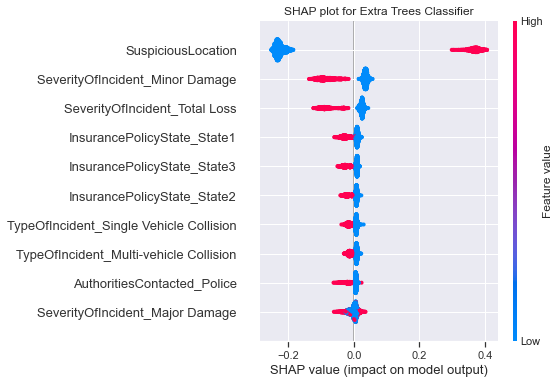

In [151]:
# shap.summary_plot() creates a density scatter plot of SHAP values for each feature to identify how much impact 
# each feature has on the model output. Features are ssorted by the sum of the SHAP value magnitudes across all samples.
fig, ax = plt.subplots(1,1)
ax.set_title("SHAP plot for Extra Trees Classifier")
shap.summary_plot(shap_values[:, :, 1], 
                  features=X_test, 
                  max_display=10)

1. SuspiciousLocation - makes the largest positive impact on fraud prediction. If claim location is a suspicious location, large positive impact on fraud prediction, and vice versa.
2. SeverityOfIncident
    - If minor damage, relatively large negative impact on fraud prediction, as compared to total loss. 

## Tune the ExtraTrees classifier (Bayesian optimization)

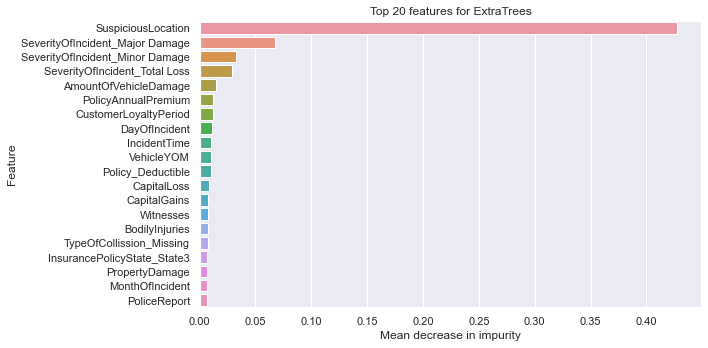

In [128]:
feature_names = [f"{X_smote.columns[i]}" for i in range(X_smote.shape[1])]

importances = xtc_model.feature_importances_

forest_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': importances}
                                    )
forest_importances = forest_importances.sort_values('importance', ascending=False)
forest_importances = forest_importances[:20] # top 20

fig, ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(y='feature', x='importance', ax=ax, data=forest_importances, orient="h")
ax.set_title("Top 20 features for ExtraTrees")
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("Feature")
fig.tight_layout()

In [123]:
seed = 1

def extratrees(n_estimators,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                max_features,
                bootstrap):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth) # Pre-pruning technique
    min_samples_split = int(min_samples_split) # Pre-pruning technique
    min_samples_leaf = int(min_samples_leaf) # Pre-pruning technique
    bootstrap = bootstrap > 0.5
    
    assert type(n_estimators) == int
    assert type(max_depth) == int
    assert type(min_samples_split) == int
    assert type(min_samples_leaf) == int


    xtc = ExtraTreesClassifier(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               bootstrap=bootstrap,
                               oob_score=bootstrap,
                               n_jobs=6,
                               random_state=seed,
                               verbose=0)

    xtc_model = xtc.fit(X_smote, y_smote)
    # use validation set to evaluate performance - F1 is our main metric
    y_pred_val = xtc_model.predict(X_val)
    return skmetrics.f1_score(y_val, y_pred_val)

In [124]:
# space to search
params = {'n_estimators': (25, 150),
          'max_depth' : (10, 200),
          'min_samples_split': (2,15),
          'min_samples_leaf' : (2,15),
          'max_features' : (.2,.8),
          'bootstrap':(0,1),
          } 

xtcBO = BayesianOptimization(extratrees, 
                            pbounds = params, 
                            random_state = seed)

print(xtcBO.space.keys)

['bootstrap', 'max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators']


In [125]:
xtcBO.maximize(init_points=6, 
               n_iter=25,
               acq = 'ucb',
               xi = 0.0,
               alpha = 1e-6)

|   iter    |  target   | bootstrap | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 1         | 0.8854    | 0.417     | 146.9     | 0.2001    | 5.93      | 3.908     | 36.54     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 2         | 0.8854    | 0.1863    | 75.66     | 0.4381    | 9.005     | 7.45      | 110.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 3         | 0.8854    | 0.2045    | 176.8     | 0.2164    | 10.72     | 7.425     | 94.84     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 4         | 0.8854    | 0.1404    | 47.64     | 0.6804    | 14.59     | 6.075     | 111.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 5         | 0.8848    | 0.8764    | 180.0     | 0.251     | 2.508     | 4.208     | 134.8     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 6         | 0.8854    | 0.09835   | 90.01     | 0.7747    | 8.931     | 10.99     | 64.44     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 7         | 0.8854    | 0.753     | 75.99     | 0.6154    | 8.275     | 5.763     | 109.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 8         | 0.8854    | 0.4562    | 190.6     | 0.5218    | 13.89     | 14.28     | 58.43     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 9         | 0.8854    | 0.03179   | 138.7     | 0.2334    | 8.505     | 14.7      | 78.46     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 10        | 0.8854    | 0.9676    | 28.08     | 0.6721    | 3.691     | 14.9      | 56.17     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 11        | 0.8854    | 0.577     | 12.59     | 0.4263    | 5.048     | 4.972     | 149.9     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 12        | 0.8854    | 0.9307    | 64.65     | 0.4157    | 7.892     | 4.586     | 25.0      |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 13        | 0.8854    | 0.4355    | 10.28     | 0.6874    | 9.594     | 9.501     | 93.39     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 14        | 0.8848    | 0.9592    | 59.42     | 0.3419    | 2.39      | 3.159     | 149.9     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 15        | 0.8854    | 0.03354   | 53.7      | 0.7086    | 12.24     | 14.18     | 79.84     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 16        | 0.8854    | 0.7881    | 109.1     | 0.6655    | 14.16     | 11.56     | 26.6      |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 17        | 0.8854    | 0.1739    | 13.21     | 0.6866    | 14.15     | 7.761     | 26.55     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 18        | 0.8834    | 0.1249    | 199.8     | 0.7704    | 4.18      | 3.511     | 25.62     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 19        | 0.8854    | 0.6583    | 117.4     | 0.3806    | 14.6      | 3.563     | 111.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 20        | 0.8854    | 0.6125    | 161.4     | 0.7979    | 14.73     | 2.222     | 67.26     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 21        | 0.8854    | 0.666     | 120.9     | 0.6202    | 5.167     | 13.84     | 148.6     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 22        | 0.8854    | 0.7727    | 199.7     | 0.2963    | 14.45     | 14.77     | 86.95     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 23        | 0.8846    | 0.8998    | 118.3     | 0.7619    | 4.164     | 2.678     | 54.63     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 24        | 0.8854    | 0.6868    | 60.98     | 0.3729    | 5.697     | 14.25     | 51.91     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 25        | 0.8854    | 0.4731    | 12.88     | 0.5155    | 14.35     | 2.026     | 120.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 26        | 0.8854    | 0.1315    | 146.8     | 0.2745    | 14.3      | 14.77     | 107.0     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 27        | 0.8854    | 0.5677    | 97.1      | 0.4482    | 14.56     | 14.23     | 95.2      |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 28        | 0.8846    | 0.9857    | 41.66     | 0.4763    | 3.921     | 13.35     | 25.55     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 29        | 0.8854    | 0.7889    | 84.06     | 0.6232    | 14.02     | 7.759     | 35.27     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 30        | 0.8854    | 0.1104    | 10.87     | 0.5453    | 11.64     | 2.93      | 60.88     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 31        | 0.8854    | 0.5438    | 34.51     | 0.3175    | 3.375     | 2.452     | 92.0      |


In [126]:
# Best Hyperparameters selected
xtcBO.max

{'target': 0.8853809196980096,
 'params': {'bootstrap': 0.417022004702574,
  'max_depth': 146.86165375401004,
  'max_features': 0.20006862489040694,
  'min_samples_leaf': 5.930323444213917,
  'min_samples_split': 3.9078265806224697,
  'n_estimators': 36.542324346099726}}

In [127]:
xtc_tuned = ExtraTreesClassifier(n_estimators = int(xtcBO.max['params']['n_estimators']),
                                    max_depth = int(xtcBO.max['params']['max_depth']),
                                    min_samples_split = int(xtcBO.max['params']['min_samples_split']),  
                                    min_samples_leaf = int(xtcBO.max['params']['min_samples_leaf']),
                                    max_features =  xtcBO.max['params']['max_features'],                 
                                    bootstrap = xtcBO.max['params']['bootstrap'] > 0.5,
                                    oob_score = xtcBO.max['params']['bootstrap'] > 0.5,
                                    n_jobs=6)

xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)

y_pred_train = xtc_tuned_model.predict(X_smote)
y_pred_train_proba = xtc_tuned_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_tuned_model.predict(X_val)
y_pred_val_proba = xtc_tuned_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_tuned_model.predict(X_test)
y_pred_test_proba = xtc_tuned_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/1080922815.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)


=====================train====================
accuracy: 0.94623
precision (macro): 0.948
recall (macro): 0.92542
f1 score (macro): 0.93562
f1 score of class 1: 0.90949
f1 score of class 0: 0.96175
pr auc score of class 1: 0.9933
pr auc score of class 0: 0.47355
=====================val====================
accuracy: 0.94209
precision (macro): 0.94529
recall (macro): 0.90615
f1 score (macro): 0.92332
f1 score of class 1: 0.88538
f1 score of class 0: 0.96126
pr auc score of class 1: 0.86589
pr auc score of class 0: 0.53606
=====================test====================
accuracy: 0.94313
precision (macro): 0.94378
recall (macro): 0.9101
f1 score (macro): 0.92514
f1 score of class 1: 0.88844
f1 score of class 0: 0.96184
pr auc score of class 1: 0.86655
pr auc score of class 0: 0.53339
